In [1]:
%matplotlib inline

import numpy as np
import sklearn.datasets as datasets

from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class RaysClusterer:
    degrees = 360
    
    def __init__(self, distance = lambda x, y: cdist(x, y, metric='euclidean')):
        self.distance = distance        
        
    def point_in_gap(self, axis, point, gap, center):
        start = np.tan(np.deg2rad(gap[0]))
        ray_start = lambda x: start * x[axis] + center[axis]

        end = np.tan(np.deg2rad(gap[1]))
        ray_end = lambda x: end * x[axis] + center[axis]
        return (ray_start(point) >= 0) and (ray_end(point) < 0)
        
    def fit(self, X):
        X = np.array(X).reshape(len(X), -1)
        self.center = np.mean(X, axis=0)
        
        self.thickness = np.mean(np.abs(X - self.center), axis=0) / np.abs(np.max(X, axis=0))
        self.degree_step = RaysClusterer.degrees / self.thickness
        
        distances = self.distance([self.center], X)[0]
        
        borders = set()
        for axis in range(X.shape[1]):
            for angle in np.arange(0, RaysClusterer.degrees, self.degree_step[axis]):
                gap = (angle, angle + self.degree_step[axis])
                points_indices = [
                    index for index, x in enumerate(X) if self.point_in_gap(
                        axis, x, gap, self.center
                    )
                ]
                array = np.zeros(shape=len(X))
                array[points_indices] = distances[points_indices]
                if np.allclose(sum(array), 0):
                    continue
                borders.add(np.argmax(array))
        
        self.borders = [
            X[index] for index in borders
        ]
        
        assignments = {}
        for border in self.borders:            
            for axis in range(X.shape[1]):
                for angle in np.arange(0, RaysClusterer.degrees, self.degree_step[axis]):
                    gap = (angle, angle + self.degree_step[axis])
                    points_indices = [
                        index for index, x in enumerate(X) if self.point_in_gap(
                            axis, x, gap, border
                        )
                    ]
                    for index in points_indices:
                        if index not in assignments:
                            assignments[index] = set(points_indices)
                        else:
                            assignments[index] = assignments[index].intersection(points_indices)
            
                        
        self.labels_ = []
        sets = {}
        for index in range(len(X)):
            point_assignments = assignments.get(index, set())
            hashed = tuple(sorted(list(point_assignments)))
            if hashed in sets:
                self.labels_.append(sets[hashed])
            else:
                sets[hashed] = max(self.labels_ or [-1]) + 1
                self.labels_.append(sets[hashed])
        
        return self

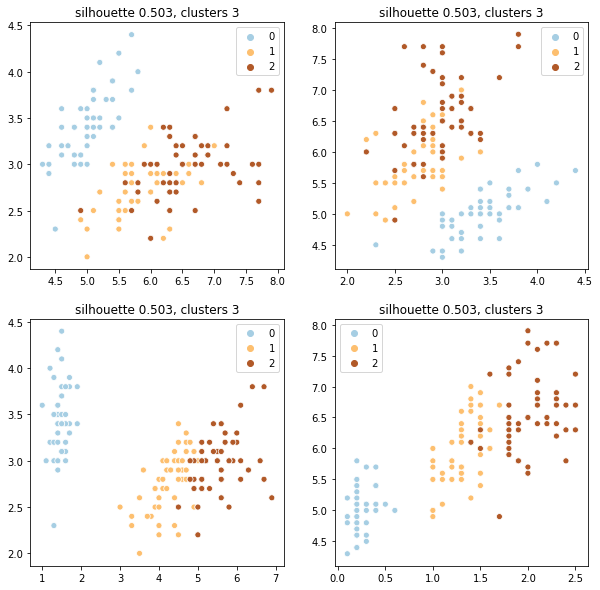

In [3]:
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN

def plot(X, pred_labels):
    plt.figure(figsize=(10, 10))
    title = "silhouette %.3f, clusters %d" % (silhouette_score(X, pred_labels), len(set(pred_labels)))
    for index in range(X.shape[1]):
        plt.subplot(max(1, X.shape[1] // 2), max(1, X.shape[1] // 2), index + 1)
        plt.title(title)
        sns.scatterplot(X[:, index], X[:, (index + 1) % max(1, X.shape[1] // 2)], hue=pred_labels, palette='Paired');

iris_X, iris_y = datasets.load_iris(return_X_y=True)
plot(iris_X, iris_y)

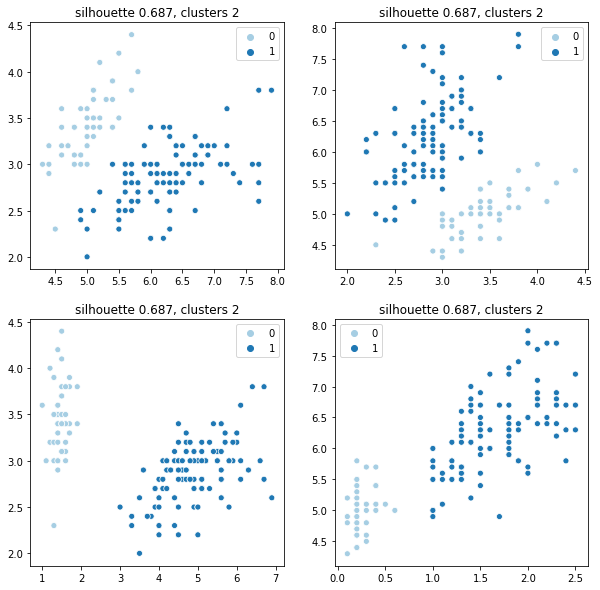

In [4]:
clusterer = RaysClusterer().fit(iris_X)
plot(iris_X, clusterer.labels_)

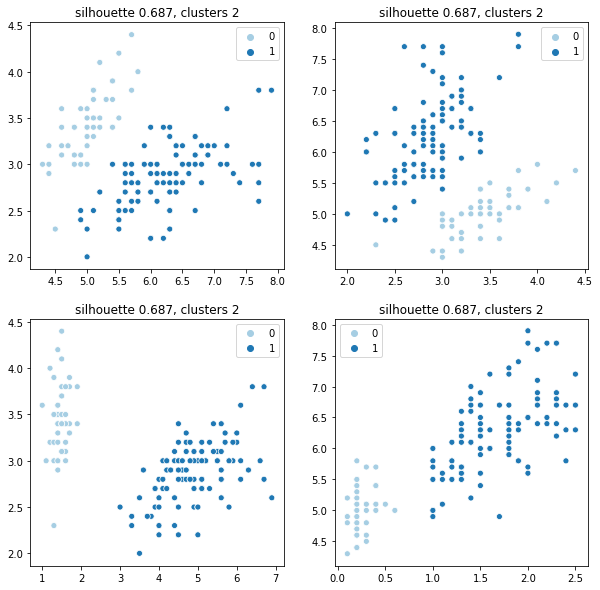

In [5]:
clusterer = DBSCAN(1).fit(iris_X)
plot(iris_X, clusterer.labels_)

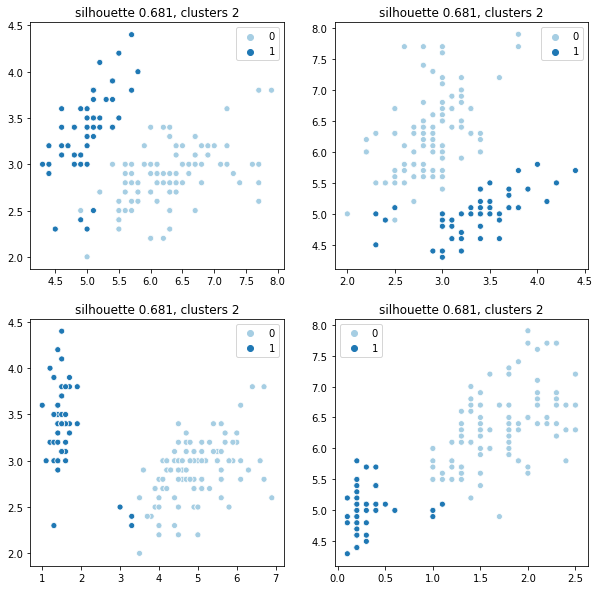

In [6]:
clusterer = KMeans(2, random_state=1).fit(iris_X)
plot(iris_X, clusterer.labels_)

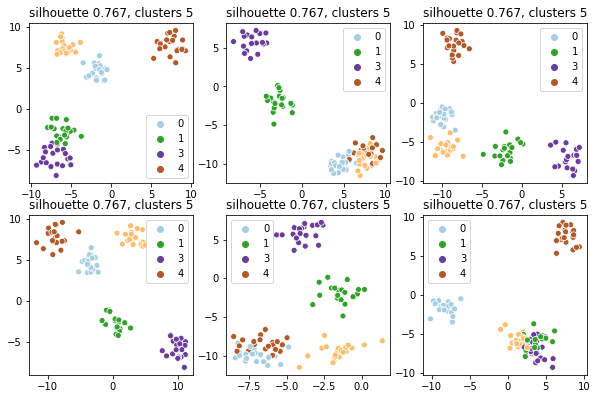

In [7]:
X, true_clusters = datasets.make_blobs(n_samples=100, centers=5, n_features=6, random_state=1)
plot(X, true_clusters)

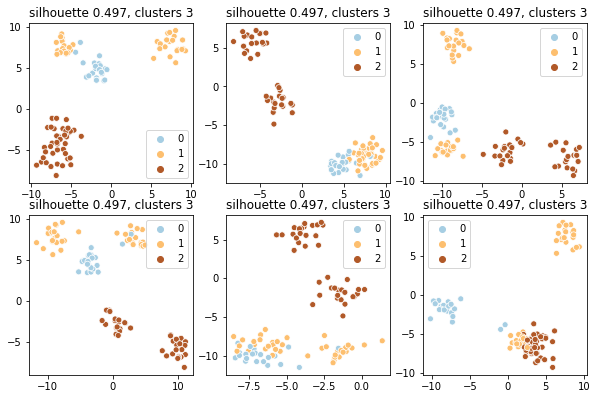

In [8]:
clusterer = RaysClusterer().fit(X)
plot(X, clusterer.labels_)

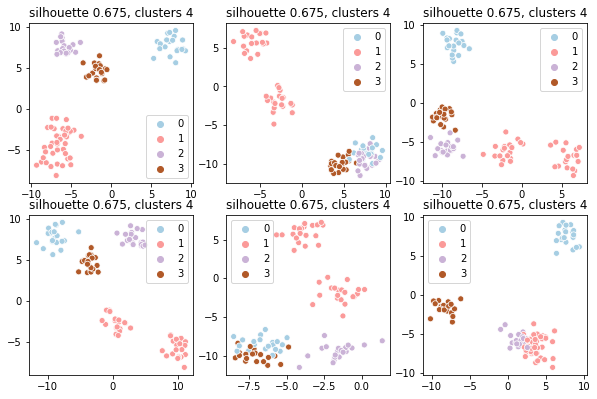

In [9]:
clusterer = KMeans(n_clusters=4).fit(X)
plot(X, clusterer.labels_)

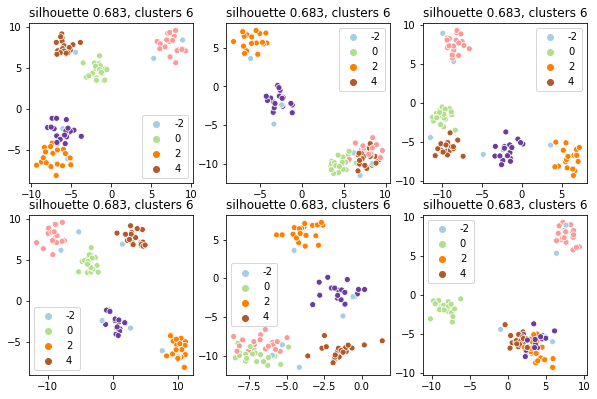

In [10]:
clusterer = DBSCAN(eps=3).fit(X)
plot(X, clusterer.labels_)